In [ ]:
# ==================================================================================
# CELDA 1: INSTALACIÓN DE DEPENDENCIAS
# ==================================================================================
print("🚀 Instalando librerías necesarias...")

!pip install -q easyocr opencv-python-headless numpy matplotlib pandas pdf2image
!apt-get install -qq poppler-utils tesseract-ocr

print("✅ Dependencias instaladas correctamente")

🚀 Instalando librerías necesarias...
✅ Dependencias instaladas correctamente


In [ ]:
# ==================================================================================
# CELDA 2: MOTORES DE PROCESAMIENTO HÍBRIDO (V3 - Lógica de Alternancia Inteligente)
# ==================================================================================

import cv2
import numpy as np
import pandas as pd
import easyocr
import json
import re
import difflib
import matplotlib.pyplot as plt
from datetime import datetime
from pdf2image import convert_from_path
import os

print("🧠 Cargando motores de procesamiento...\n")

# ==================================================================================
# MOTOR 1: CONTEXTO BOLIVIANO
# ==================================================================================
class BolivianContext:
    """Diccionario ampliado con nombres y lugares comunes de Bolivia"""

    def __init__(self):
        self.APELLIDOS = [
            "QUISPE", "MAMANI", "FLORES", "CONDORI", "CHOQUE", "VARGAS", "GUTIERREZ",
            "ROJAS", "LOPEZ", "CRUZ", "ALIAGA", "COLQUE", "OROZCO", "CHURQUI",
            "LANDAETA", "CHAVEZ", "COLLAO", "LUNA", "BUSTILLOS", "CHACON", "CUTILI",
            "LINARES", "PATI", "ARGANDOÑA", "DELGADILLO", "ESPEJO", "SIRPA", "PRIMY",
            "MENDIETA", "AGUILERA", "PALMA", "LLAMPA", "CALLISAYA", "GONZALES",
            "TANGARA", "RODRIGUEZ", "MORALES", "RIVERO", "SIÑANI", "URIARTE", "SUXO",
            "CARREÑO", "LIMA", "ESPADA", "LARREA", "ORMACHEA", "ALVAREZ", "PEREZ",
            "MARIACA", "ESTRADA", "GUACHALLA", "VERA", "MARQUEZ", "ANCASI", "PARI",
            "ALABY", "ALAVI", "NAVIA", "CORNEJO", "LUNARIO", "ANTEZANA", "RIVERA",
            "MEJIA", "VALVERDE", "YAVE", "VILELA", "DORADO", "SIDNEY", "MIRANDA",
            "PEÑALOZA", "PALACIOS", "LIZARAZU", "REVOLLO", "BOGADO", "MONASTERIOS",
            "ZAPANA", "ORIHUELA", "GOSALVEZ", "QUISBERT", "OCXA", "SILVA", "RAMOS",
            "ARUQUIPA", "MAURICIO", "RICALDI", "SALINAS", "VILLALTA", "VELARDE", "GAMARRA",
            "FERNANDEZ", "GARCIA", "MARTINEZ", "SANCHEZ", "RAMIREZ", "TORRES", "DIAZ",
            "HERRERA", "MEDINA", "CASTRO", "ROMERO", "SOTO", "CONTRERAS", "JIMENEZ"
        ]

        self.NOMBRES = [
            "JUAN", "MARIA", "JOSE", "LUIS", "ANA", "CARLOS", "ROSA", "MIGUEL",
            "JORGE", "ELIZABETH", "GERALDINE", "ANGELA", "MICAELA", "LIZETH",
            "ILSEN", "SUMEY", "LIVIA", "VIOLETA", "ILSE", "PATRICIA", "LUZ",
            "MARINA", "NAYELI", "BRIGITTE", "HELEN", "NINEL", "TATIANA", "MARIO",
            "JHENY", "RUBEN", "MARCELO", "CAROLA", "FRANKLIN", "JANNETTE",
            "ROSARIO", "HUGO", "AQUINO", "LAURA", "ORLANDO", "ENRIQUE", "FABIOLA",
            "STEPHANIA", "PETER", "EDGAR", "ROY", "ANGEL", "XIMENA", "GERMAN",
            "MARGARITA", "FRANCO", "EDWIN", "HUMBERTO", "HILARIA", "ADRIAN",
            "VICTOR", "SILVIA", "AMOROSA", "GUILLERMO", "NICOLE", "MACIEL",
            "OSMAR", "ZOBEIDA", "IVON", "ALAN", "IVAN", "NESTOR", "JAVIER",
            "FREDDY", "JHOSELIN", "BELEN", "RONALD", "XAVIER", "GILKA", "CARLO",
            "FELIPE", "ANDREE", "HIRIBERTO", "ELVIRA", "MOISES", "ALEXIS", "MITZI",
            "CAMILA", "GIOVANNA", "SANDRO", "SAUL", "CLIVER", "DELMA", "ALEJANDRA",
            "ALEX", "NINETT", "VIVIANA", "VANIA", "PABLO", "ANTONIO", "IVER",
            "RONAL", "TERESA", "MAGDA", "JOAQUIN", "MARLENY", "ROSEMERY", "NORKA",
            "SAMANTHA", "MICHELLE", "EDDY", "MICHAEL", "CECILIA", "GABRIELA",
            "GUSTAVO", "RODOLFO", "PEDRO", "SANTIAGO", "DIEGO", "FERNANDO", "RICARDO",
            "DANIEL", "ANDRES", "MANUEL", "FRANCISCO", "RAUL", "SERGIO", "ROBERTO"
        ]

        self.LUGARES = [
            "LA PAZ", "EL ALTO", "SAN PEDRO", "NUEVA PAZ", "SAN ANTONIO",
            "PADUA", "FATIMA", "SAN SEBASTIAN", "LA MERCED", "SANTO DOMINGO",
            "SANTA CRUZ", "COCHABAMBA", "ORURO", "POTOSI", "TARIJA",
            "SUCRE", "BENI", "PANDO", "CHUQUISACA"
        ]

    def correct_text(self, raw_text, category="GENERAL"):
        if not raw_text or len(raw_text) < 2:
            return raw_text

        raw_upper = raw_text.upper().strip()
        words = raw_upper.split()
        corrected_words = []

        if category == "LUGAR":
            dictionary = self.LUGARES
            threshold = 0.7
        else:
            dictionary = self.NOMBRES + self.APELLIDOS
            threshold = 0.75

        for word in words:
            if len(word) <= 2:
                corrected_words.append(word)
                continue

            matches = difflib.get_close_matches(word, dictionary, n=1, cutoff=threshold)
            if matches:
                corrected_words.append(matches[0])
            else:
                corrected_words.append(word)

        return " ".join(corrected_words)

# ==================================================================================
# MOTOR 2: DETECCIÓN DE GRID (MODIFICADO)
# ==================================================================================
class GridDetector:
    def __init__(self):
        self.debug_mode = True
        self.TARGET_COLS = 10
        # Mantenemos 25 para capturar bien las líneas, la limpieza fuerte se hace en el loop principal
        self.MIN_ROW_HEIGHT = 25

    def get_structure(self, img):
        print("   📐 Detectando estructura (10 Columnas Fijas)...")

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)
        H, W = img.shape[:2]

        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (W // 30, 1))
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, H // 40))

        h_lines = cv2.dilate(cv2.erode(thresh, h_kernel), h_kernel)
        v_lines = cv2.dilate(cv2.erode(thresh, v_kernel), v_kernel)

        # --- FILAS (YS) ---
        raw_ys = self.find_peaks(h_lines, 1)
        # Fusión inicial
        ys = self.merge_lines(raw_ys, thr=20)

        # --- COLUMNAS (XS) ---
        raw_xs = np.sum(v_lines, axis=0)
        peak_indices = np.where(raw_xs > np.max(raw_xs) * 0.1)[0]

        candidate_lines = self.merge_lines(list(peak_indices), thr=20)

        # Lógica para forzar 11 líneas (10 columnas)
        if len(candidate_lines) > 11:
            line_strengths = []
            for x in candidate_lines:
                start = max(0, x - 5)
                end = min(len(raw_xs), x + 5)
                strength = np.sum(raw_xs[start:end])
                line_strengths.append((x, strength))

            line_strengths.sort(key=lambda item: item[1], reverse=True)
            top_lines = line_strengths[:11]
            top_lines.sort(key=lambda item: item[0])
            xs = [x for x, s in top_lines]
        else:
            xs = candidate_lines

        # Asegurar bordes
        if not ys or ys[0] > 50: ys.insert(0, 0)
        if ys[-1] < H - 50: ys.append(H)

        if not xs or xs[0] > 50: xs.insert(0, 0)
        if xs[-1] < W - 50: xs.append(W)

        print(f"   📍 Columnas detectadas: {len(xs)-1} (Forzadas a patrón 10)")
        print(f"   📍 Filas detectadas (Candidatas): {len(ys)-1}")

        if self.debug_mode:
            self._plot_debug(img, xs, ys)

        return ys, xs

    def find_peaks(self, mask, axis):
        proj = np.sum(mask, axis=axis)
        return sorted(list(np.where(proj > np.max(proj) * 0.2)[0]))

    def merge_lines(self, lines, thr=20):
        if len(lines) == 0: return []
        merged = [lines[0]]
        for x in lines[1:]:
            if x - merged[-1] > thr:
                merged.append(x)
        return merged

    def _plot_debug(self, img, xs, ys):
        debug_img = img.copy()
        for y in ys: cv2.line(debug_img, (0, y), (img.shape[1], y), (0, 255, 0), 2)
        for x in xs: cv2.line(debug_img, (x, 0), (x, img.shape[0]), (0, 0, 255), 2)
        plt.figure(figsize=(10, 6))
        plt.title(f"Malla Ajustada")
        plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# ==================================================================================
# MOTOR 3: PROCESADOR OCR
# ==================================================================================
class ManuscriptOCR:
    def __init__(self):
        print("   🔧 Inicializando EasyOCR...")
        self.reader = easyocr.Reader(['es', 'en'], gpu=True)
        self.corrector = BolivianContext()
        self.scale_factor = 2.5

    def preprocess_cell(self, cell_img):
        if cell_img.shape[0] < 8 or cell_img.shape[1] < 8: return None
        gray = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        gray = cv2.resize(gray, None, fx=self.scale_factor, fy=self.scale_factor, interpolation=cv2.INTER_CUBIC)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        binary = cv2.dilate(binary, kernel, iterations=1)
        binary = cv2.copyMakeBorder(binary, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=255)
        return binary

    def read_cell(self, cell_img, col_type="text"):
        processed = self.preprocess_cell(cell_img)
        if processed is None: return ""

        allowlist = '0123456789/' if col_type == "date" else None

        try:
            results = self.reader.readtext(processed, detail=0, paragraph=False, allowlist=allowlist)
            raw_text = " ".join(results).strip()

            if not raw_text:
                results = self.reader.readtext(cell_img, detail=0, paragraph=False)
                raw_text = " ".join(results).strip()

            if col_type == "date":
                return self._format_date(raw_text)
            else:
                return self.corrector.correct_text(raw_text, "GENERAL")

        except Exception as e:
            return ""

    def _format_date(self, text):
        text = text.upper().replace('O', '0').replace('D', '0').replace('B', '8').replace('S', '5')
        nums = re.sub(r'[^\d]', '', text)
        if len(nums) == 6: return f"{nums[:2]}/{nums[2:4]}/{nums[4:]}"
        elif len(nums) == 8: return f"{nums[:2]}/{nums[2:4]}/{nums[4:8]}"
        return nums if nums else text

# ==================================================================================
# MOTOR 4: ORQUESTADOR PRINCIPAL (V3)
# ==================================================================================
class HybridHTRProcessor:

    def __init__(self):
        self.grid_detector = GridDetector()
        self.ocr_engine = ManuscriptOCR()
        self.min_chars_per_row = 3
        # PATRÓN FIJO: L,N,N,N,L,N,N,N,L,L
        self.FIXED_PATTERN = ['text', 'date', 'date', 'date', 'text', 'date', 'date', 'date', 'text', 'text']

    def process_image(self, img):
        print("\n" + "="*70)
        print("   🚀 PROCESAMIENTO HÍBRIDO (Modo Alternancia Inteligente)")
        print("="*70)

        print("\n[PASO 1] Detección de estructura")
        ys, xs = self.grid_detector.get_structure(img)

        print("\n[PASO 3] Lectura OCR y Filtrado")
        data = []
        real_row_idx = 1

        start_idx = 0
        if len(ys) > 1 and (ys[1] - ys[0] < 40):
            start_idx = 1

        # --- LÓGICA DE ALTERNANCIA ---
        # Flag para sugerir que la siguiente fila es ruido
        expect_noise_next = False
        prev_row_height = 0

        for i in range(start_idx, len(ys) - 1):
            y1, y2 = ys[i], ys[i + 1]
            row_height = y2 - y1

            # 1. Filtro Básico de Altura (Basura muy pequeña)
            if row_height < 20:
                continue

            # 2. Lógica de Alternancia Inteligente
            # Si esperamos ruido (porque la anterior fue válida) Y esta fila es "delgada"
            if expect_noise_next:
                # Si la fila actual es menor al 75% de la anterior, confirmamos que es separador
                if prev_row_height > 0 and row_height < (prev_row_height * 0.75):
                    print(f"   ⏭️ Fila {i+1} SALTADA (Detectada como separación/ruido: {row_height}px)")
                    expect_noise_next = False # Reiniciamos para buscar la siguiente válida
                    continue
                else:
                    # Si la fila es grande, el modelo falló en predecir ruido, así que la procesamos
                    print(f"   ⚠️ Fila {i+1} (Esperaba ruido, pero es alta {row_height}px. Procesando...)")

            print(f"   📝 Proc. Fila {real_row_idx} (h={row_height}px)...", end=" ")

            temp_row = []
            row_text_content = ""

            max_cols = min(len(xs) - 1, len(self.FIXED_PATTERN))

            for j in range(max_cols):
                x1, x2 = xs[j], xs[j + 1]
                cell = img[y1+2:y2-2, x1+2:x2-2]

                c_type = self.FIXED_PATTERN[j]
                text = self.ocr_engine.read_cell(cell, col_type=c_type)

                if c_type == "text":
                    row_text_content += text

                temp_row.append({
                    "col": j + 1,
                    "tipo": "L" if c_type == "text" else "N",
                    "valor": text
                })

            # Validar contenido
            clean_content = re.sub(r'[\d\s]', '', row_text_content)
            if len(row_text_content.strip()) < 3 and len(clean_content) < 2:
                 print("❌ VACÍA (ignorada)")
                 # Si falló la validación, NO activamos expect_noise_next,
                 # porque quizás la siguiente sí es la buena.
                 expect_noise_next = False
                 continue

            print(f"✅ VÁLIDA")
            data.append({"fila": real_row_idx, "datos": temp_row})
            real_row_idx += 1

            # ÉXITO: Marcamos que la siguiente probablemente sea ruido
            expect_noise_next = True
            prev_row_height = row_height

        print(f"\n{'='*70}")
        print(f"   ✅ COMPLETADO: {len(data)} filas válidas extraídas")
        print(f"{'='*70}\n")
        return data

    def export_results(self, data, output_filename="resultado_htr.json"):
        with open(output_filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"💾 Resultados guardados en: {output_filename}")
        return output_filename

    def to_dataframe(self, data):
        rows = []
        for item in data:
            row = {}
            for d in item['datos']:
                row[f"Col{d['col']}_{d['tipo']}"] = d['valor']
            row['Fila'] = item['fila']
            rows.append(row)
        df = pd.DataFrame(rows)
        cols = ['Fila'] + [c for c in sorted(df.columns) if c.startswith('Col')]
        return df[cols]

print("✅ MOTORES CARGADOS CORRECTAMENTE (Alternancia Activada)\n")
print("📌 Usa la siguiente celda para procesar tu imagen")

🧠 Cargando motores de procesamiento...

✅ MOTORES CARGADOS CORRECTAMENTE (Alternancia Activada)

📌 Usa la siguiente celda para procesar tu imagen


🖼️  Sube tu imagen (PNG, JPG) o PDF...



Saving Tabla2.pdf to Tabla2 (6).pdf

✅ Archivo cargado: Tabla2 (6).pdf

📄 Convirtiendo PDF a imagen...

📸 Imagen Original:


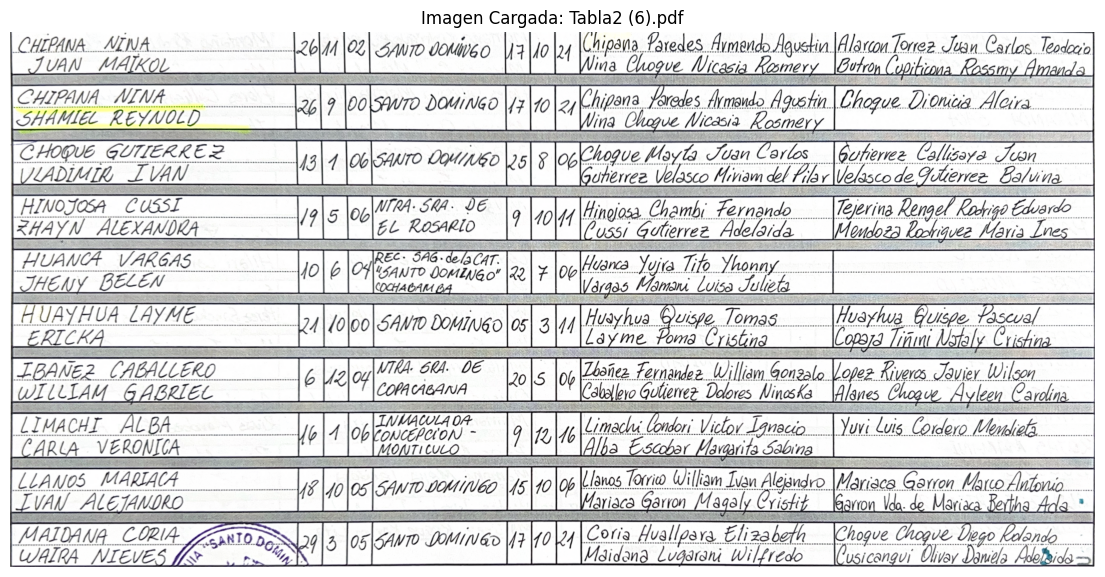

   🔧 Inicializando EasyOCR...

   🚀 PROCESAMIENTO HÍBRIDO (Modo Alternancia Inteligente)

[PASO 1] Detección de estructura
   📐 Detectando estructura (10 Columnas Fijas)...
   📍 Columnas detectadas: 10 (Forzadas a patrón 10)
   📍 Filas detectadas (Candidatas): 19


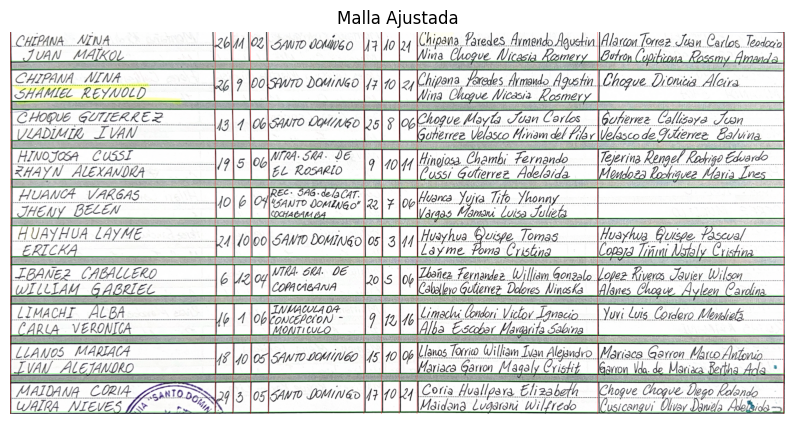


[PASO 3] Lectura OCR y Filtrado
   📝 Proc. Fila 1 (h=310px)... ✅ VÁLIDA
   ⏭️ Fila 2 SALTADA (Detectada como separación/ruido: 83px)
   📝 Proc. Fila 2 (h=331px)... ✅ VÁLIDA
   ⏭️ Fila 4 SALTADA (Detectada como separación/ruido: 83px)
   📝 Proc. Fila 3 (h=325px)... ✅ VÁLIDA
   ⏭️ Fila 6 SALTADA (Detectada como separación/ruido: 80px)
   📝 Proc. Fila 4 (h=322px)... ✅ VÁLIDA
   ⏭️ Fila 8 SALTADA (Detectada como separación/ruido: 80px)
   📝 Proc. Fila 5 (h=321px)... ✅ VÁLIDA
   ⏭️ Fila 10 SALTADA (Detectada como separación/ruido: 79px)
   📝 Proc. Fila 6 (h=321px)... ✅ VÁLIDA
   ⏭️ Fila 12 SALTADA (Detectada como separación/ruido: 80px)
   📝 Proc. Fila 7 (h=320px)... ✅ VÁLIDA
   ⏭️ Fila 14 SALTADA (Detectada como separación/ruido: 80px)
   📝 Proc. Fila 8 (h=327px)... ✅ VÁLIDA
   ⏭️ Fila 16 SALTADA (Detectada como separación/ruido: 79px)
   📝 Proc. Fila 9 (h=323px)... ✅ VÁLIDA
   ⏭️ Fila 18 SALTADA (Detectada como separación/ruido: 79px)
   📝 Proc. Fila 10 (h=320px)... ✅ VÁLIDA

   ✅ COMPLE

,Fila,Col10_L,Col1_L,Col2_N,Col3_N,Col4_N,Col5_L,Col6_N,Col7_N,Col8_N,Col9_L
0,1,ALARCON JORTEZ_SJUNN_CARLOS . BUTRON (UO;HIRNN...,CHEPANA NINA JUAN MAIKOL,26,4,02,SANTD OONWGO,13,0,24,[CHIPÊNA_{AXESLES_AXMANDO AQUINO WINA CHOQUE A...
1,2,DIONICIA_ALCIRA CHOQUE,CHIPANA NINA SHAMIEL REYNOLD,26,9,00,SAWTD DQMINGN,7,10,2,(CHIPANA XREDES_{XMAWLO_HQUSHIN WINA OVOUE ANC...
2,3,GUTIERREZ CALLISEXA_JUN VELSCODE GUTIERREZ BAL...,CHONU6 GUTIERREZ VLADIMIA IVAN,18,1,0,BANTO DQUINKGD,25,8,06,CHOQUE @XÚ_UAN@ERLOS_ GUHERREZVELESCO MFIAM & ...
3,4,TEJEXINA_RENQEL_KORIQ? EDUAXD_ MEMDOZA LORIQVE...,HINOJOA C USSI RHAYN ALEJANDRA,9,5,06,NTRA' SIRPA UE 6L ROSARIO,9,0,//,HINEJOS: CHAMBI_FERNANDE PUSSI GUTIERREZ ADELOIDA
4,5,,HUANCA VARGAS JHENY DEZEN,10,0,,REC 5A6.DLACAT. {ANTD OOMLNGO' COHHABAM 04,22,7,06,HUANE_ YUJTA_ IIK_YHONN MAMANI LUIÓA JULIET 1/...
5,6,HUAXHUA UISPE_FSWAL COPIA TININI MSLALV CRISHINA,HUAYHUA LAYME ERICKA,1,10,90,3ANND DOMINGO,05,3,4,HUAYHUA_ UIGPE_TOMAS LAYME POMA CRISLINA
6,7,LOPEZ _KIVERO_SIAUIEX_WILSON ALAN CHOU; AVLEEN...,IBANEZ LABALLERO UILLIAM GABRIELA,6,19,04,NTRA' 5NA. DE COPACAEANA,20,5,06,ZONEZ_TEXNANLEZ_WILLIAM_GONZAL [CABDLEYO QUTIE...
7,8,YUVI CPRDERQ_VLOUDIEF LUIS,LIMACHI BA CAROLA VERONICA AL,46,1,06,INMACULAOA KONCEPC'ON MONTICULC,9,12,16,LIMACHI_UANDOI_VICOX_IINACIO ALAN {SCOBAR VARO...
8,9,Q2((PN ANTONIO KAYRON VD DO MARIA REXTHA MAGDA...,LLANOS MARIACA IVAN ALEIANIRO,18,40,0,SAN70 DOMIIV6O,15,10,06,LANOS_LRI WLLIAM LVEN ALEINDRO MARIACA GARRON ...
9,10,ZDONDL [CUSICANWVI 0VADANEL 77303I0- DIPQ? CHQ...,MAIDANA_ CORIA UAIRA NIEVES ZAANIQDGMA,29,3,05,YANTD DOMINGD,1,10,21,CORIA_ HUALLPANA_EIZABGTH MEDINA LUGAÍONI WILF...



⬇️  Descargando resultados...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 PROCESO COMPLETADO EXITOSAMENTE


In [ ]:
# ==================================================================================
# CELDA 3: PROCESAMIENTO DE IMAGEN
# ==================================================================================

from google.colab import files
import IPython.display as display

print("🖼️  Sube tu imagen (PNG, JPG) o PDF...\n")
uploaded = files.upload()

if not uploaded:
    print("❌ No se subió ningún archivo")
else:
    filename = list(uploaded.keys())[0]
    print(f"\n✅ Archivo cargado: {filename}\n")

    # Cargar imagen
    if filename.lower().endswith('.pdf'):
        print("📄 Convirtiendo PDF a imagen...")
        pages = convert_from_path(filename, dpi=200)
        img = cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(filename)

    # Mostrar imagen original
    print("\n📸 Imagen Original:")
    plt.figure(figsize=(14, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Imagen Cargada: {filename}")
    plt.axis('off')
    plt.show()

    # Crear procesador
    processor = HybridHTRProcessor()

    # Procesar
    resultados = processor.process_image(img)

    # Exportar JSON
    json_file = processor.export_results(resultados, f"{filename.split('.')[0]}_resultado.json")

    # Mostrar DataFrame
    print("\n📊 Vista previa de resultados:\n")
    df = processor.to_dataframe(resultados)
    display.display(df)

    # Descargar resultados
    print("\n⬇️  Descargando resultados...")
    files.download(json_file)

    print("\n🎉 PROCESO COMPLETADO EXITOSAMENTE")

---

## 📝 Notas Técnicas

### Mejoras vs. HTRSacra360:
1. **Grid robusto**: Usa detección por morfología de OCRv2 (más confiable)
2. **Preprocesamiento mejorado**: CLAHE + zoom 2.5x + dilatación controlada
3. **Multi-intento**: Si falla con preprocesamiento, reintenta sin él
4. **Corrección contextual**: Diccionario ampliado con 150+ nombres/apellidos
5. **Filtrado inteligente**: Elimina filas vacías automáticamente

### Parámetros ajustables:
- `scale_factor`: Zoom aplicado (default 2.5)
- `min_chars_per_row`: Mínimo de caracteres para considerar fila válida (default 3)
- `clipLimit` en CLAHE: Intensidad de mejora de contraste (default 3.0)

### Limitaciones:
- Requiere líneas de tabla visibles (aunque sean tenues)
- Funciona mejor con márgenes claros entre celdas
- Manuscritos muy cursivos pueden requerir ajuste de parámetros

---